In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

# Daten einlesen

In [2]:
df = pd.read_csv('../data/DEvideos.csv')

## Tags parsen und in listen umwandeln

In [3]:
def isValidTag(s):
    return s != '[none]'

df['parsed_tags'] = df['tags'].str.split('|')\
    .apply(lambda x: [n.strip('\"') for n in x])\
    .where(isValidTag)
df['parsed_tags'].head()

0    [inscope21, sing zu ende, gesangseinlagen, ges...
1    [Kinder, ferngesteuert, Kinder ferngesteuert, ...
2    [last week tonight trump presidency, last week...
3    [Physik, Wissenschaft, Technik, Science-Fictio...
4    [kelly, missesvlog, kelly song, bausa, bausa w...
Name: parsed_tags, dtype: object

## Calculate tag counts

In [4]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
tag_counts = to_1D(df['parsed_tags']).value_counts()

## Display top 20 tags

d:\programme\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

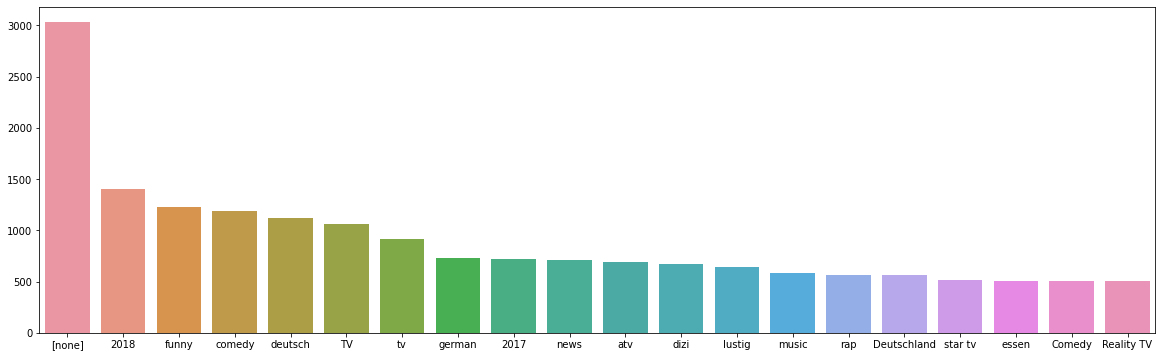

In [5]:
top_tags = tag_counts.head(20)
sns.barplot(top_tags.index, top_tags.values)

# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

## Convert tags into their own table

In [6]:
tags_df = df['parsed_tags'].apply(pd.Series)
tags_df.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,inscope21,sing zu ende,gesangseinlagen,gesang,gesungen,songs nachsingen,nachsingen,songs covern,carpool karaoke,witziger gesang,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kinder,ferngesteuert,Kinder ferngesteuert,luke mockridge kinder,luke die woche und ich kinder,Prank,verarschen,Kiosk,Funkgerät,Falschgeld,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,last week tonight trump presidency,last week tonight donald trump,john oliver trump,donald trump,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Physik,Wissenschaft,Technik,Science-Fiction,Außerirdische,Alien,Aliens,Fermi,Fermi-Paradoxon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kelly,missesvlog,kelly song,bausa,bausa was du liebe nennst,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate tag usage

In [7]:
tags_df.iloc[:, 0].value_counts(normalize=True)

[none]                                                           0.074216
atv                                                              0.008570
çukur                                                            0.005607
fox                                                              0.005069
шарий                                                            0.004383
                                                                   ...   
Muss das Bein amputiert werden? Wildschwein-Angriff im Garten    0.000024
Fiese Entführung: An den Piercings festgekettet!                 0.000024
airforceluna                                                     0.000024
Flucht vorm Jugendamt: Vermisste Familie im Wohnwagen            0.000024
wrexham fc                                                       0.000024
Name: 0, Length: 10672, dtype: float64

## Convert tags to binary table

In [8]:
def boolean_df(item_lists, items):
    bool_dict={}
    for i, item in enumerate(items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

#unique_items = tag_counts.where(lambda x: x > 500).dropna().index
unique_items = tag_counts.head(40).tail(20).index
head_tags = df['parsed_tags']
tags_bool = boolean_df(head_tags, unique_items)
tags_bool.head()

,humor,review,SAT.1,video,Highlights,diy,yeni dizi,challenge,DIY,hd,comedian,AfD,vlog,youtube,tricks,show,kochen,Fußball,funny video,izle
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Tags as correlation matrix

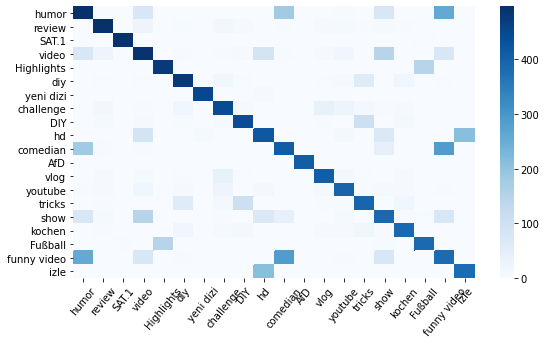

In [9]:
tags_int = tags_bool.astype(int)
tags_freq_mat = np.dot(tags_int.T, tags_int)

fruits_freq = pd.DataFrame(tags_freq_mat, columns = unique_items, index = unique_items)

fix, ax = plt.subplots(figsize = (9,5))
sns.heatmap(fruits_freq, cmap = "Blues")
plt.xticks(rotation=50)
plt.savefig("heatmap.png", dpi = 300)